# The Application of a VAE to Galaxy Spectra

## Introduction

Spectroscopy has provided the foundation for our modern understanding of galaxy formation and
evolution. Deep, wide-field spectroscopic and imaging surveys are presenting us
with vast amounts of new data on the evolution of galaxies. Upcoming surveys will provide orders of magnitude more data than any
previous survey. With classical techniques becoming insufficient to handle this data, it is clear that
we have a need to expand our analysis tool kit. For this expansion we turn towards unsupervised machine learning, where insights can be drawn from data with no pre-existing labels.

We use a variational autoencoder (VAE) to create compressed representations of galaxy spectra. These spectra were synthetically generated using the Flexible Stellar Population Synthesis package (see Conroy et al. 2009 and Conroy and Gunn 2010) and have a number of physical parameters associated with them. However, the model never sees these parameters during training. What we are interested in is whether the model can learn notions of these parameters in the latent representations by just looking at the spectra.

Here, I share the code that was used to do this. I'm no computer scientist, so the code is at times sloppy. I hope that it can inspire more people to explore the application of VAEs to scientific discovery.

## The Basics

We begin by importing the packages required. We have a mix of packages for statistical or aesthetic purposes, and of course those required for the machine learning aspect.

In [1]:
# import general packages
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import seaborn as sns
import random
from mycolorpy import colorlist as mcp
from gmm_mi.mi import EstimateMI

# import ML packages
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, random_split
from torchsummary import summary

# set matplotlib text parameters
plt.rcParams["text.usetex"] = True
plt.rcParams["font.size"] = "11"
plt.rcParams["font.family"] = "serif"

We load the spectra, as well as the parameters associated with them. These files can be found in the drive linked in the README file.

In [2]:
# retrieve data
spectra = np.load("training_spectra.npy")
wavelengths = np.load("wavelengths.npy")
parameters = genfromtxt('parameters.csv', delimiter=',')

We then perform some initial handling of the data. In particular, we normalise the data to speed up the training process and reduce fluctuations. This can code can definitely be written better but it works.

In [3]:
# initial data handling
wavelength_low = 1000
wavelength_high = 10000
reduced_wavelengths = []
reduced_indices = []
for i in range(len(wavelengths)):
    x = wavelengths[i]
    if x >= wavelength_low and x <= wavelength_high:
      reduced_wavelengths.append(x)
      reduced_indices.append(i)
reduced_spectra = spectra[:, reduced_indices[0] : reduced_indices[-1] + 1]

# normalise the data by median
normalization_low = 5000
normalization_high = 5500
normalization_wavelengths = [x for x in reduced_wavelengths if x >= normalization_low and x <= normalization_high]

for i in range(len(reduced_wavelengths)):
  if reduced_wavelengths[i] == normalization_wavelengths[0]:
    lower_index = i
  if reduced_wavelengths[i] == normalization_wavelengths[-1]:
    upper_index = i

normalization_fluxes = reduced_spectra[:, lower_index : upper_index + 1]
reduced_spectra_normalized = reduced_spectra

for i in range(len(normalization_fluxes)):
  fluxes = normalization_fluxes[i, :]
  median = np.median(fluxes)
  reduced_spectra_normalized[i, :] = reduced_spectra_normalized[i, :] / median

# get just the parameters
parameters = parameters[1:, 1:]

Some spectra are plotted to visualise what our data looks like.

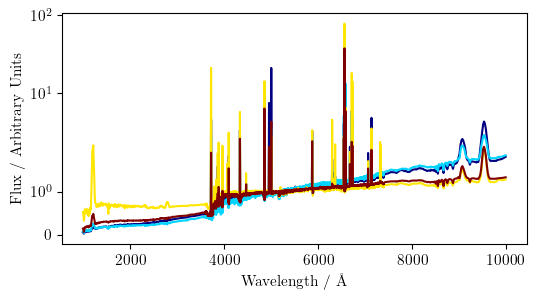

In [4]:
# plot some spectra
plt.figure(figsize = (6, 3))
num_spectra = 4
colours = "jet"
cmap = mcp.gen_color(cmap = colours, n = num_spectra)
for i in range(num_spectra):
   spectrum_number = np.random.randint(99999, dtype = int)
   spectrum = reduced_spectra_normalized[spectrum_number, :]
   plt.plot(reduced_wavelengths, spectrum, color = cmap[i])

plt.xlabel('Wavelength / Å')
plt.ylabel('Flux / Arbitrary Units')
plt.yscale('symlog')
plt.show()

We define some variables that control our model and its training. We define a path to save the model to. Of course, if you choose to use the code yourself you can change the path as necessary.

In [5]:
# select a device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# transform the data to a tensor and then a dataset
reduced_spectra_normalized_tensor = torch.Tensor(reduced_spectra_normalized)
reduced_spectra_normalized_tensor = reduced_spectra_normalized_tensor.to(torch.float32)
reduced_spectra_normalized_tensor = reduced_spectra_normalized_tensor.reshape(reduced_spectra_normalized_tensor.shape[0], 1, reduced_spectra_normalized_tensor.shape[1])
spectra_dataset = torch.utils.data.TensorDataset(reduced_spectra_normalized_tensor)

# set up the master training parameters
batch_size = 32
learning_rate = 3e-4
epochs = 100
beta = 0.3
beta_increase = 0 
split_frac = 0.2
loss_reduction_threshold = 20
num_params = parameters.shape[1]

# set up the master network parameters
image_channels = 1
init_channels = 16
latent_dim = 32
kernel = 3
stride = 2
dropout_prob = 0
input_length = len(reduced_spectra_normalized[0])

# set the number of convolutional layer blocks of 2 (not including inital convolution, i.e. total number of convolutional layers = 1 + 2 * n_conv)
n_conv = 5

#split the data
train_size = int(np.floor(reduced_spectra_normalized.shape[0] * (1 - split_frac)))
validation_size = int(reduced_spectra_normalized.shape[0] - train_size)
training, validation = random_split(spectra_dataset, [train_size, validation_size])

# create train and validation dataloaders
train_loader = DataLoader(dataset = training, batch_size = batch_size, shuffle = True, num_workers = 4, pin_memory = True)
valid_loader = DataLoader(dataset = validation, batch_size = batch_size, shuffle = True, num_workers = 4, pin_memory = True)

# choose a path to save the model
path = r"E:/University/III/Research Project/Notebooks/Models/VAE.pth"

cuda


## The Model and Training

We define our class of model.

In [6]:
# define the VAE model
class VAE(nn.Module):
    def __init__(self, n_conv, input_length, image_channels, init_channels, latent_dim, kernel, stride, dropout_prob, device):
        super(VAE, self).__init__()

        # encoder
        encoder_layers = []
        encoder_layers.append(nn.Conv1d(image_channels, init_channels, kernel_size = kernel, stride = stride))
        encoder_layers.append(nn.LeakyReLU(0.2))
        encoder_layers.append(nn.Dropout1d(dropout_prob))
        output_size = self.encoder_out_size(input_length, kernel, stride)

        for i in range(n_conv):
            in_channels = init_channels * (2 ** i)
            out_channels = init_channels * (2 ** (i + 1))
            encoder_layers.append(nn.Conv1d(in_channels, out_channels, kernel_size = kernel, stride = stride))
            encoder_layers.append(nn.LeakyReLU(0.2))
            encoder_layers.append(nn.Dropout1d(dropout_prob))
            output_size = self.encoder_out_size(output_size, kernel, stride)
            encoder_layers.append(nn.Conv1d(out_channels, out_channels, kernel_size = kernel, stride = stride))
            encoder_layers.append(nn.LeakyReLU(0.2))
            encoder_layers.append(nn.Dropout1d(dropout_prob))
            output_size = self.encoder_out_size(output_size, kernel, stride)
            
        encoder_layers.append(nn.Flatten())
        out_dim = output_size * out_channels

        self.encoder = nn.Sequential(*encoder_layers)

        # latent mean and variance
        self.mean_layer = nn.Linear(out_dim, latent_dim)
        self.log_var_layer = nn.Linear(out_dim, latent_dim)

        # decoder
        decoder_layers = []
        decoder_layers.append(nn.Linear(latent_dim, out_dim))
        decoder_layers.append(nn.LeakyReLU(0.2))
        decoder_layers.append(nn.Unflatten(1, (out_channels, output_size)))

        for i in range(n_conv):
            in_channels = init_channels * (2 ** (n_conv - i))
            out_channels = init_channels * (2 ** (n_conv - i - 1))
            decoder_layers.append(nn.ConvTranspose1d(in_channels, in_channels, kernel_size = kernel, stride = stride))
            decoder_layers.append(nn.LeakyReLU(0.2))
            decoder_layers.append(nn.Dropout1d(dropout_prob))
            output_size = self.decoder_out_size(output_size, kernel, stride)
            decoder_layers.append(nn.ConvTranspose1d(in_channels, out_channels, kernel_size = kernel, stride = stride))
            decoder_layers.append(nn.LeakyReLU(0.2))
            decoder_layers.append(nn.Dropout1d(dropout_prob))
            output_size = self.decoder_out_size(output_size, kernel, stride)

        decoder_layers.append(nn.ConvTranspose1d(init_channels, image_channels, kernel_size = kernel, stride = stride))
        decoder_layers.append(nn.LeakyReLU(0.2))
        self.output_size = self.decoder_out_size(output_size, kernel, stride)
        decoder_layers.append(nn.Linear(self.output_size, input_length))

        self.decoder = nn.Sequential(*decoder_layers)

    # define the encoder output size function
    def encoder_out_size(self, L_in, kernel, stride):
         L = (L_in - kernel) // stride + 1
         return L

    # define the decoder output size function
    def decoder_out_size(self, L_in, kernel, stride):
        L = (L_in - 1) * stride + kernel
        return L

    # define the other functions we need
    def encode(self, x):
        x = self.encoder(x)
        mean, log_var = self.mean_layer(x), self.log_var_layer(x)
        return mean, log_var

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)
        z = mean + var * epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        x_hat = self.decode(z)
        return x_hat, mean, log_var, z

# define the loss function
def loss_function(x, x_hat, mean, log_var, beta):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction = 'sum')
    KLD = - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + beta * KLD, reproduction_loss, KLD

We implement and summarise the model.

In [7]:
# create the model
model = VAE(n_conv, input_length, image_channels, init_channels, latent_dim, kernel, stride, dropout_prob, device = device).to(device)
optimizer = Adam(model.parameters(), lr = learning_rate, weight_decay = 0.1)
scheduler = lr_scheduler.StepLR(optimizer, 10, gamma = 0.5)

# show the summary
summary(model, (1, input_length))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 16, 2290]              64
         LeakyReLU-2             [-1, 16, 2290]               0
         Dropout1d-3             [-1, 16, 2290]               0
            Conv1d-4             [-1, 32, 1144]           1,568
         LeakyReLU-5             [-1, 32, 1144]               0
         Dropout1d-6             [-1, 32, 1144]               0
            Conv1d-7              [-1, 32, 571]           3,104
         LeakyReLU-8              [-1, 32, 571]               0
         Dropout1d-9              [-1, 32, 571]               0
           Conv1d-10              [-1, 64, 285]           6,208
        LeakyReLU-11              [-1, 64, 285]               0
        Dropout1d-12              [-1, 64, 285]               0
           Conv1d-13              [-1, 64, 142]          12,352
        LeakyReLU-14              [-1, 

We define the training function for the model.

In [8]:
# define the training function
def train(model, optimizer, scheduler, epochs, beta, beta_increase, device):
    epoch_nums = []
    training_losses = []
    validation_losses = []
    reproduction_losses = []
    KLDs = []
    counter = 0
    threshold = False
    lowest_epoch = 1

    for epoch in range(epochs):

        # training
        model.train()
        total_training_loss = 0
        total_reproduction_loss = 0
        total_KLD = 0
        
        for batch_idx, x in enumerate(train_loader):
 
            x = x[0]
            x = x.to(device)
            optimizer.zero_grad()
            x_hat, mean, log_var, z = model(x)
            training_loss, reproduction_loss, KLD = loss_function(x, x_hat, mean, log_var, beta)
            total_training_loss += training_loss.item()
            total_reproduction_loss += reproduction_loss.item()
            total_KLD += KLD.item()
            batch_number = batch_idx

            training_loss.backward()
            optimizer.step()

        epoch_nums.append(epoch + 1)
        avg_training_loss = total_training_loss / batch_number
        avg_reproduction_loss = total_reproduction_loss / batch_number
        avg_KLD = total_KLD / batch_number
        training_losses.append(avg_training_loss)
        reproduction_losses.append(avg_reproduction_loss)
        KLDs.append(avg_KLD)
        
 
        # validation
        with torch.no_grad():
            model.eval()
            total_validation_loss = 0
            for batch_idx, x in enumerate(valid_loader):

                x = x[0]
                x = x.to(device)
                x_hat, mean, log_var, z = model(x)
                validation_loss, reproduction_loss, KLD = loss_function(x, x_hat, mean, log_var, beta)
                total_validation_loss += validation_loss.item()
                batch_number = batch_idx

        avg_validation_loss = total_validation_loss / batch_number
        validation_losses.append(avg_validation_loss)

        # results
        print("\tEpoch", epoch + 1, "\tTraining Loss: ", np.round(avg_training_loss), "\tValidation Loss: ", np.round(avg_validation_loss), "\tReconstruction Loss: ", np.round(avg_reproduction_loss), "\tKL Divergence: ", np.round(avg_KLD))
 
        # early stopping and best model
        if epoch != 0:
            if avg_validation_loss > min(validation_losses):
              counter += 1
            else:
              counter = 0
              lowest_epoch = epoch + 1
              torch.save(model.state_dict(), path)
            if counter == loss_reduction_threshold and loss_reduction_threshold != 0:
              threshold = True
        if threshold == True: break

        # lr scheduler + beta step
        scheduler.step()
        beta += beta_increase

    return epoch_nums, training_losses, validation_losses, lowest_epoch, reproduction_losses, KLDs

Then the model is trained.

In [9]:
# train the model - note - the losses are averaged over the batches in an epoch
epoch_nums, training_losses, validation_losses, lowest_epoch, reproduction_losses, KLDs = train(model, optimizer, scheduler, epochs, beta, beta_increase, device = device)

	Epoch 1 	Training Loss:  91639.0 	Validation Loss:  54683.0 	Reconstruction Loss:  91069.0 	KL Divergence:  1899.0
	Epoch 2 	Training Loss:  18618.0 	Validation Loss:  18323.0 	Reconstruction Loss:  18126.0 	KL Divergence:  1640.0
	Epoch 3 	Training Loss:  11514.0 	Validation Loss:  9434.0 	Reconstruction Loss:  11072.0 	KL Divergence:  1472.0
	Epoch 4 	Training Loss:  10465.0 	Validation Loss:  9109.0 	Reconstruction Loss:  10086.0 	KL Divergence:  1264.0
	Epoch 5 	Training Loss:  7128.0 	Validation Loss:  3666.0 	Reconstruction Loss:  6744.0 	KL Divergence:  1277.0
	Epoch 6 	Training Loss:  4361.0 	Validation Loss:  2936.0 	Reconstruction Loss:  3994.0 	KL Divergence:  1223.0
	Epoch 7 	Training Loss:  2704.0 	Validation Loss:  2366.0 	Reconstruction Loss:  2324.0 	KL Divergence:  1266.0
	Epoch 8 	Training Loss:  1972.0 	Validation Loss:  812.0 	Reconstruction Loss:  1601.0 	KL Divergence:  1238.0
	Epoch 9 	Training Loss:  2341.0 	Validation Loss:  2090.0 	Reconstruction Loss:  2000.

We visualise how the model has performed at each stage of training.

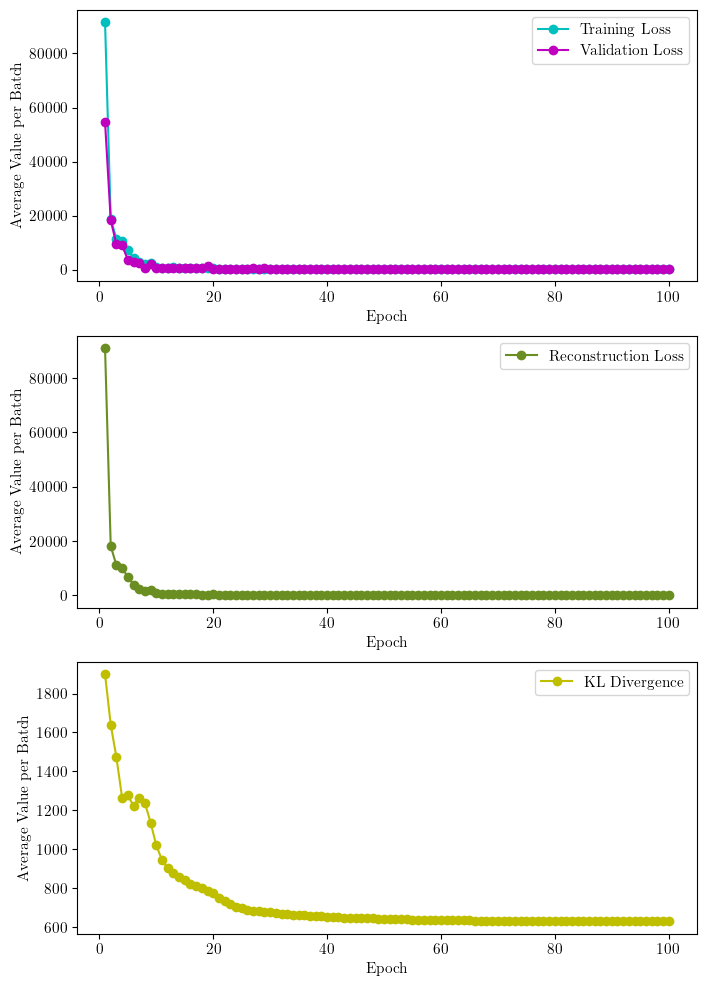

In [10]:
# loss plots
plt.figure(figsize = (8, 12))

plt.subplot(3, 1, 1)
plt.plot(epoch_nums, training_losses, linestyle = '-', marker = 'o', color = 'c', label = 'Training Loss')
plt.plot(epoch_nums, validation_losses, linestyle = '-', marker = 'o', color = 'm', label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Value per Batch')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(epoch_nums, reproduction_losses, linestyle = '-', marker = 'o', color = 'olivedrab', label = 'Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Value per Batch')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(epoch_nums, KLDs, linestyle = '-', marker = 'o', color = 'y', label = 'KL Divergence')
plt.xlabel('Epoch')
plt.ylabel('Average Value per Batch')
plt.legend()

plt.show()

## Performance Analysis

We load the best performing model, which we choose to be the one with the lowest validation loss. This suggests that it has the best general performance. We then load the latent representations and reconstructions learnt by this model.

In [11]:
# load the best model
model.load_state_dict(torch.load(path))

# get the latent representations
latent_representations = []
recons = []
for spectrum in reduced_spectra_normalized_tensor[:]:
    x = spectrum.to(device)
    x = x.reshape(1, 1, input_length)
    x_hat, mean, log_var, z = model(x)
    z = z.reshape(latent_dim,)
    latent_representations.append(z.detach().cpu().numpy())
    recons.append(x_hat.detach().cpu().numpy().reshape((input_length,)))

We Visualise how the reconstructed spectra compare with the originals. Reconstruction quality is important, as poor reconstruction quality suggests that the model is not learning useful features of the input data.

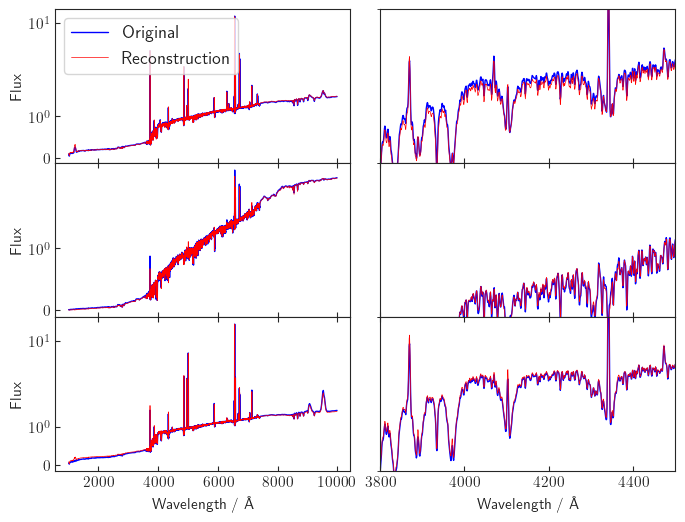

In [29]:
# change parameters for plotting
rand = True
num_spectra = 3
indices = [0, 1, 2]

# adjust for random or chosen indices
if rand:
    indices = []
    for _ in range(num_spectra):
        indices.append(np.random.randint(99999, dtype = int))
else:
    num_spectra = len(indices)

# choose the limits for the zoomed in spectra
left = 3800
right = 4500
top = 1.1
bottom = 0.5

# create the figure
fig, axes = plt.subplots(figsize = (8, 2 * num_spectra), ncols = 2, nrows = num_spectra, sharex = 'col')
plt.subplots_adjust(hspace = 0, wspace = 0.1)

# plot the figure
for i in range(num_spectra):
    index = indices[i]
    orig = reduced_spectra_normalized[index]
    recon = recons[index]

    axes[i, 0].plot(reduced_wavelengths, orig, 'b', label = 'Original', linewidth = 1)
    axes[i, 0].plot(reduced_wavelengths, recon, 'r', label = 'Reconstruction', linewidth = 0.5)
    axes[i, 0].set_yscale('symlog')
    axes[i, 0].set_ylabel('Flux')
    axes[i, 0].tick_params(axis = 'both', which = 'major', direction = 'in')
    if i == 0:
        axes[i, 0].legend(fontsize = 13)
    else:
        axes[i, 0].tick_params(top = True)
    if i == num_spectra - 1:
        axes[i, 0].set_xlabel('Wavelength / Å')
    
    axes[i, 1].plot(reduced_wavelengths, orig, 'b', label = 'Original', linewidth = 1)
    axes[i, 1].plot(reduced_wavelengths, recon, 'r', label = 'Reconstruction', linewidth = 0.5)
    axes[i, 1].set_yscale('symlog')
    axes[i, 1].set_yticks([])
    axes[i, 1].set_xlim(left = left, right = right)
    axes[i, 1].set_ylim(top = top, bottom = bottom)
    axes[i, 1].tick_params(axis = 'both', which = 'major', direction = 'in')
    if i != 0:
        axes[i, 1].tick_params(top = True)
    if i == num_spectra - 1:
        axes[i, 1].set_xlabel('Wavelength / Å')

plt.show()


We assess the informativeness of each latent dimension. We use the mean absolute covariance of the dimensions with the input data to quantify this. A dimension is labelled as informative if this result is above some value. Inspired by Burda et al. (2016), we set this initially to 0.01. A visualisation of the scores is then plotted.

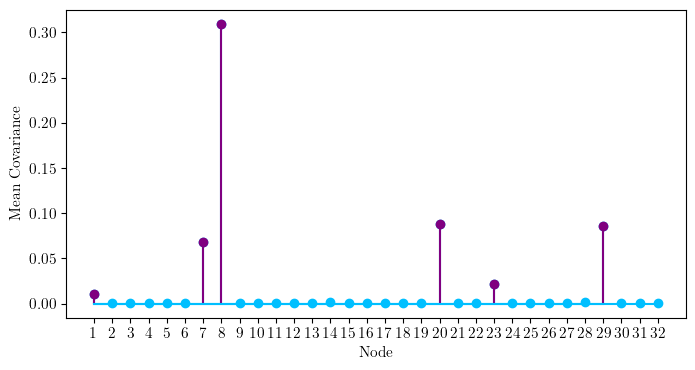

In [13]:
# covariance with inputs
covariances = []

for i in range(latent_dim):
    dim_values = []
    for elem in latent_representations:
        dim_values.append(elem[i])   

    dim_covariances = []
    
    for j in range(input_length):
        data = []
        for spectrum in reduced_spectra_normalized[:]:
            data.append(spectrum[j])
        covariance = abs(np.cov(dim_values, data)[0][1])
        
        dim_covariances.append(covariance)
        
    covariances.append(dim_covariances)
    
cov_means = [np.mean(i) for i in covariances]

# set the informative threshold
inf_thresh = 0.01

# calculate the informative dimensions
informative_dims = []
cov_inf = []
for i in range(latent_dim):
    if cov_means[i] > inf_thresh:
        informative_dims.append(i + 1)
        cov_inf.append(cov_means[i])

# plot the covariances
x = np.linspace(1, latent_dim, latent_dim)
x = [int(k) for k in x]
plt.figure(figsize = (8, 4))
plt.stem(x, cov_means, 'deepskyblue', basefmt = 'deepskyblue')
plt.stem(informative_dims, cov_inf, 'purple', basefmt = 'deepskyblue')
plt.xlabel('Node')
plt.xticks(x)
plt.ylabel('Mean Covariance')
plt.show()

We plot the mutual behaviour of the informative dimensions. This allows us to see if they have been disentagled, i.e. they are independent.

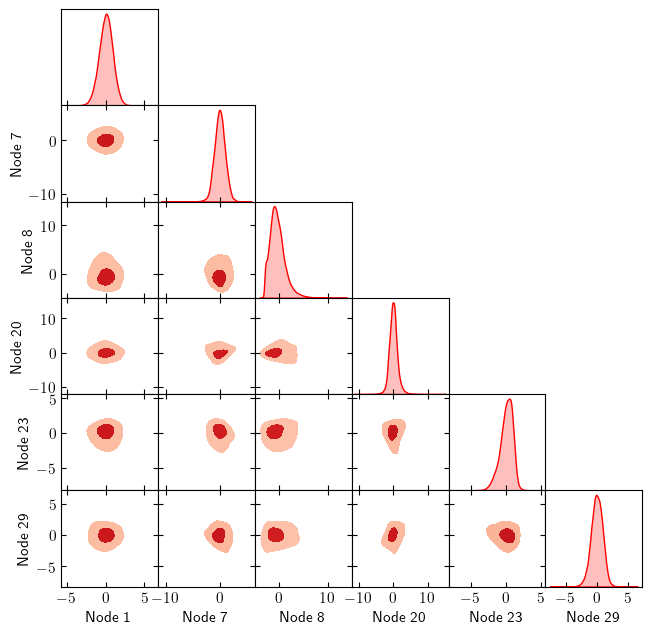

In [14]:
# triangle plot
num_inf = len(informative_dims)
dim_values = []
for dim in informative_dims:
    this_dim_values = []
    for elem in latent_representations:
        this_dim_values.append(elem[dim - 1])
    dim_values.append(this_dim_values)

fig, axes = plt.subplots(figsize = (7.5, 7.5), ncols = num_inf, nrows = num_inf, sharex = 'col')
sns.set_style("ticks")
cmap = "Reds"
c = "r"
plt.subplots_adjust(wspace = 0, hspace = 0)
for i in range(num_inf):
    for j in range(num_inf):
        if i < j:
            axes[i, j].axis('off')
        else:

            if i == j:
                sns.kdeplot(x = dim_values[i], fill = True, ax = axes[i, j], color = c)
                axes[i, j].set_ylabel('')
                axes[i, j].tick_params(top = False, bottom = True, left = False, right = False)
            else:
                sns.kdeplot(x = dim_values[j], y = dim_values[i], cmap = cmap, fill = True, ax = axes[i, j], levels = 3, bw_adjust = 2)
                axes[i, j].tick_params(top = True, bottom = True, left = True, right = True)
            if i == num_inf - 1:
                axes[i, j].set_xlabel(f'Node {informative_dims[j]}')
            else:
                axes[i, j].tick_params(labelbottom = False)
            if j == 0 and i != 0:
                axes[i, j].set_ylabel(f'Node {informative_dims[i]}')
            else:
                axes[i, j].tick_params(labelleft = False)
            axes[i, j].tick_params(axis = 'both', which = 'major', direction = 'in')

plt.show()

## Physical Analysis

We measure the mutual information using the GMM-MI package (Piras et al. 2023). This quantifies how strongly related the latent dimensions and the physical parameters are.

In [17]:
# measure MI
MI_matrix = []
MI_errors = []
MI_estimators = []
for i in range(num_params):
    MI_vals = []
    errors = []
    estimators = []
    param_values = np.array(parameters[:, i])

    for dim in informative_dims:
        dim_values = []
        for elem in latent_representations:
            dim_values.append(elem[dim - 1])
        dim_values = np.array(dim_values)
        estimator = EstimateMI()
        MI, error = estimator.fit_estimate(dim_values, param_values)
        MI_vals.append(MI)
        errors.append(error)
        estimators.append(estimator)

    MI_matrix.append(MI_vals)
    MI_errors.append(errors)
    MI_estimators.append(estimators)

100%|██████████| 50/50 [04:56<00:00,  5.93s/it]
e:\Python\Python\Lib\site-packages\gmm_mi\mi.py:499: ConvergenceWarning: All CV GMM fits converged only after their second iteration for all components; this is usually suspicious, and might be a symptom of a bad fit. Plot the loss curves as described in the walkthrough, and try reducing threshold_fit, or with a different init_type.
  warnings.warn(
100%|██████████| 50/50 [00:31<00:00,  1.59it/s]


We plot a heatmap of the mutual information results.

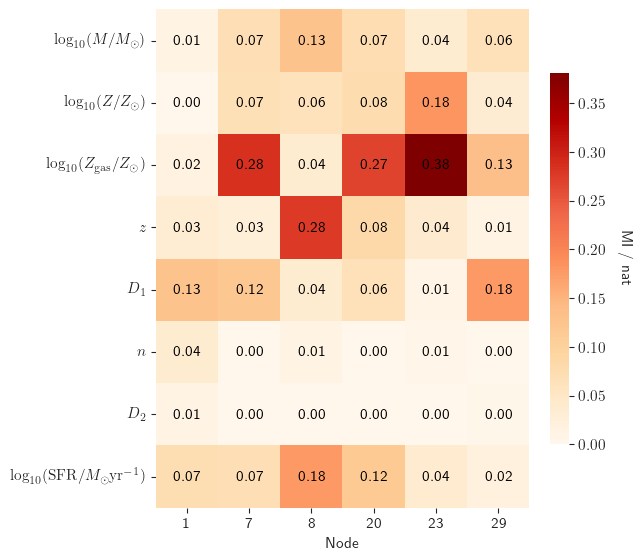

In [18]:
# setup dictionary
param_dict = {1: r'$\mathrm{log}_{10}(M/M_\odot)$',
              2: r'$\mathrm{log}_{10}(Z/Z_\odot)$',
              3: r'$\mathrm{log}_{10}(Z_\mathrm{gas}/Z_\odot)$',
              4: r'$z$',
              5: r'$D_1$',
              6: r'$n$',
              7: r'$D_2$',
              8: r'$\mathrm{log}_{10}(\mathrm{SFR}/M_\odot \mathrm{yr}^{-1})$'
              }

# setup the heatmap
heatmap_data = np.array(MI_matrix)
x = informative_dims.copy()
y = [param_dict[j + 1] for j in range(num_params)]
plt.figure(figsize = (6.3, 7.2))
ax = sns.heatmap(heatmap_data, cmap = 'OrRd', vmin = 0, xticklabels = x, yticklabels = y, annot = True, square = True, annot_kws = {'fontsize': 11, 'color': 'black'}, fmt = '.2f', cbar_kws={"fraction": 0.045})
cax = ax.figure.axes[-1]
cax.set_ylabel('MI / nat', rotation = 270, labelpad = 20)
plt.yticks(rotation = 0)
plt.tight_layout()
plt.xlabel('Node')
plt.show()

To better interpret the results of the mutual information calculations, we visualise the relations between the parameters and the informative dimensions. The relations with a mutual information above a certain value are shown in green, whereas the others are shown in red.

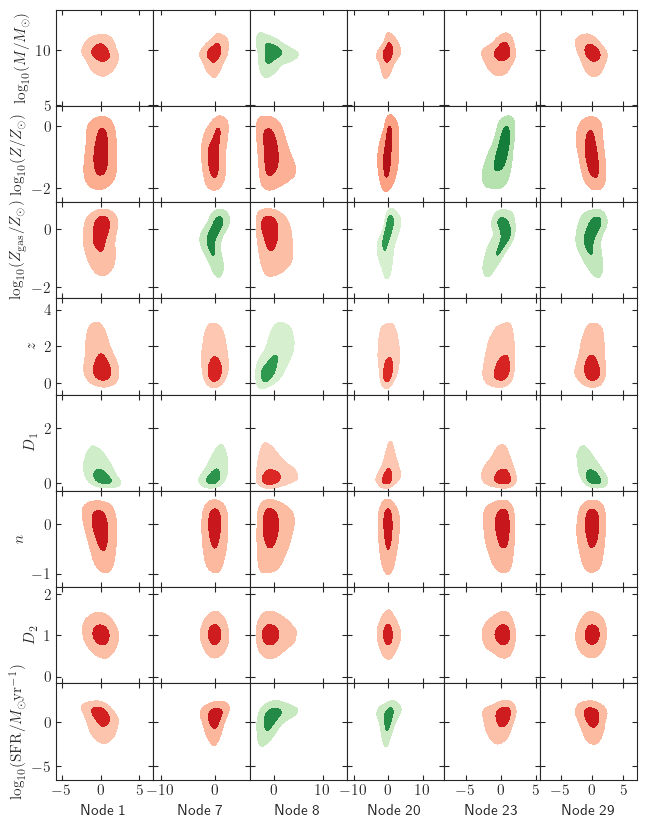

In [24]:
# select an MI cutoff to draw attention to certain relations
MI_cut = 0.1

# plot the relations
fig, axes = plt.subplots(num_params, num_inf, figsize = (7.5, 10))
sns.set_style("ticks")
plt.subplots_adjust(wspace = 0, hspace = 0)
for i, dim in enumerate(informative_dims):
    dim_values = []
    for elem in latent_representations:
        dim_values.append(elem[dim - 1])
    for j in range(num_params):
        param_values = parameters[:, j]

        dim_param_MI = heatmap_data[j][i]
        if dim_param_MI > MI_cut:
            cmap = "Greens"
        else:
            cmap = "Reds"

        sns.kdeplot(x = dim_values, y = param_values, cmap = cmap, fill = True, ax = axes[j, i], levels = 3, bw_adjust = 2)
        axes[j, i].tick_params(top = True, bottom = True, left = True, right = True)
        axes[j, i].tick_params(axis = 'both', which = 'major', direction = 'in')

        if i == 0:
            axes[j, i].set_ylabel(param_dict[j + 1])
        else:
            axes[j, i].tick_params(labelleft = False)
        if j == num_params - 1:
            axes[j, i].set_xlabel(f'Node {dim}')
        else:
            axes[j, i].tick_params(labelbottom = False)
        
plt.show()


Finally, we perform latent space traversal. By taking a spectrum and its latent representation, we may vary one dimension at a time to better understand what information has been captured. We utilise the generative capabilities of the model to generate new spectra that we compare with the original.

54779


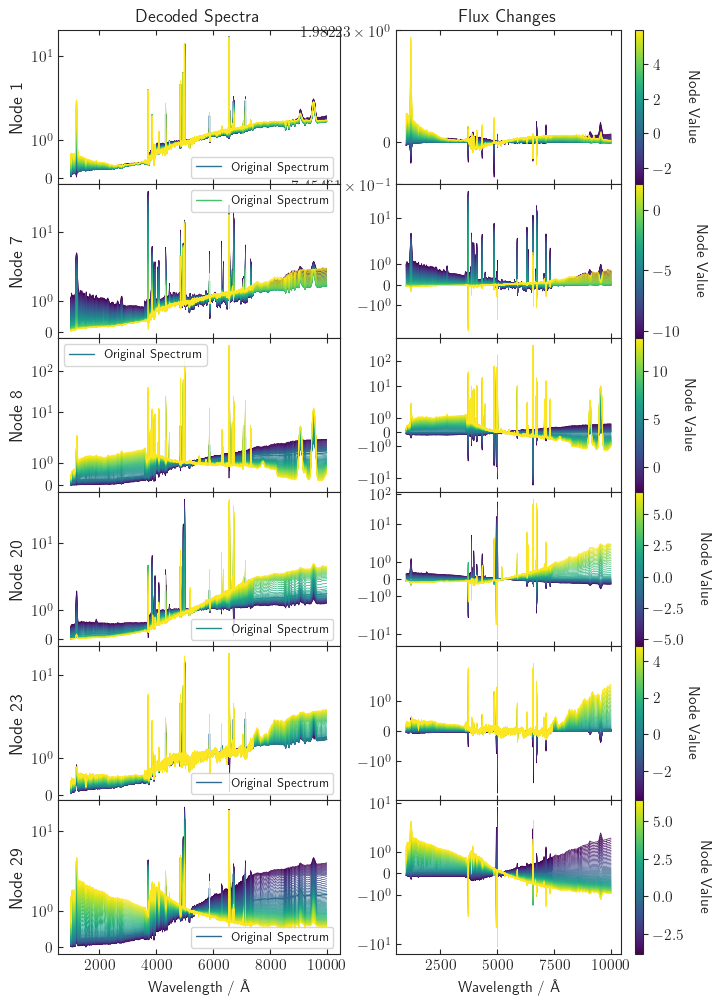

In [28]:
# get the spectrum and latent
random_index = True
if random_index:
    index = random.randint(0, reduced_spectra_normalized_tensor.shape[0] - 1)
    print(index)
else:
    index = 42370

z = np.copy(latent_representations[index])
z_tensor = torch.tensor(z).to(device)
z_tensor = z_tensor.reshape(1, latent_dim).to(torch.float32)
original = model.decode(z_tensor).detach().cpu().reshape(input_length,)

# latent traversal

# create the figure
fig, axes = plt.subplots(num_inf, 2, figsize = (8, 2 * num_inf), sharex = 'col')
plt.subplots_adjust(hspace = 0)
for j, dim in enumerate(informative_dims):
    dim_values = []
    for elem in latent_representations:
        dim_values.append(elem[dim - 1])
    z_target_up = max(dim_values)
    z_target_down = min(dim_values)
    z_original = z[dim - 1]

    # traversal parameters
    colours = "viridis"
    cutoff = True
    full_traversal = True
    num_steps = 50
    if full_traversal:
        z_diff_up = (z_target_up - z_original) / num_steps
        z_diff_down = (z_target_down - z_original) / num_steps
    else:
        z_diff_up = 0.1
        z_diff_down = -0.1

    # get new spectra
    decoded_spectra = []
    min_found = False
    for i in range(num_steps):
        z_new = z.copy()
        z_new[dim - 1] = z_original + (num_steps - i) * z_diff_down
        z_new = torch.tensor(z_new).to(device)
        z_new = z_new.reshape(1, latent_dim).to(torch.float32)
        spectrum = model.decode(z_new).detach().cpu().reshape(input_length,)
        if cutoff:
            if min(spectrum) > 0:
                decoded_spectra.append(spectrum)
                if not min_found:
                    min_z = z_original + (num_steps - i) * z_diff_down
                    min_found = True
        else:
            decoded_spectra.append(spectrum)
            min_z = z_original + (num_steps - i) * z_diff_down
        
    
    decoded_spectra.append(original)
    original_index = len(decoded_spectra)
    
    for i in range(num_steps):
        z_new = z.copy()
        z_new[dim - 1] = z_original + (1 + i) * z_diff_up
        z_new = torch.tensor(z_new).to(device)
        z_new = z_new.reshape(1, latent_dim).to(torch.float32)
        spectrum = model.decode(z_new).detach().cpu().reshape(input_length,)
        if cutoff:
            if min(spectrum) < 0: break
        max_z = z_original + (1 + i) * z_diff_up
        decoded_spectra.append(spectrum)

    num_spectra = len(decoded_spectra)

    # residuals plot
    axes[j, 1].set_yscale('symlog')
    axes[j, 1].tick_params(axis = 'both', which = 'major', direction = 'in')
    axes[j, 1].tick_params(top = True, bottom = True, left = True)
    cmap = mcp.gen_color(cmap = colours, n = num_spectra)
    sm = plt.cm.ScalarMappable(cmap = colours, norm = plt.Normalize(vmin = min_z, vmax = max_z))
    cbar = plt.colorbar(sm, ax = axes[j, 1])
    cbar.set_label('Node Value', rotation = 270, labelpad = 20)
    
    for i in range(num_spectra):
        residual = np.array(decoded_spectra[i]) - np.array(original)
        axes[j, 1].plot(reduced_wavelengths, residual, color = cmap[i], linewidth = 0.5)

    # spectra plot
    for i in range(num_spectra):
        if i == original_index:
            axes[j, 0].plot(reduced_wavelengths, decoded_spectra[i], color = cmap[i], label = 'Original Spectrum', linewidth = 1)
        else:
            axes[j, 0].plot(reduced_wavelengths, decoded_spectra[i], color = cmap[i], linewidth = 0.5)
    
    axes[j, 0].set_ylabel(f'Node {dim}', fontsize = 13)
    axes[j, 0].set_yscale('symlog')
    axes[j, 0].tick_params(axis = 'both', which = 'major', direction = 'in')
    axes[j, 0].tick_params(top = True, bottom = True, left = True)
    axes[j, 0].legend(fontsize = 9)

axes[0, 0].set_title('Decoded Spectra', fontsize = 13)
axes[0, 1].set_title('Flux Changes', fontsize = 13)
axes[num_inf - 1, 0].set_xlabel('Wavelength / Å')
axes[num_inf - 1, 1].set_xlabel('Wavelength / Å')

plt.show()

## Conclusion

Here, we have presented the code for the application of a VAE to galaxy spectra, as well as the subsequent analysis. The detail provided here has been somewhat limited. A full discussion of the results for a previous training of the model, as well as a full reference list, can be found in the accompanying report. I once again would like you to forgive me for my poor coding.